# About this notebook

This notebook is based on Coursera's course "Machine learning" by Prof. Andrew Ng from Stanford University. In this course, all codes are written in Octave or Matlab. This notebook provides the Python version of the codes.

This notebook is based on the Exerxise 5. Key words are as follows:
- Cross validation
- Regularized linear regression
- Cost function
- Hypothesis
- Bias-variance
- Learning curves
- Polynomial regression
- Fearture normalization

# Regularized Linear Regression and Bias v.s. Variance

## Data preparation

The dataset is stored in the matlab file "<strong>ex5dat1.mat</strong>." This dataset contains historical records on the change in the water level X and the amount of water flowing out of the dam y. This dataset can be divided into three parts:
- A training set that your model will learn on: X, y
- A cross validation set for determining the regularization parameter: Xval, yval
- A test set for evaluating performance. These are "unseen" examples which your model did not see during training: Xtest, ytest

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.optimize import minimize
import copy
from statistics import mean,stdev


path=os.getcwd()

datpath=path + '/ex5data1.mat'

dat=loadmat(datpath)
print(dat.keys())

X0=dat['X']
X=np.insert(X0, 0, 1, axis=1) # Add 1 to the first column of the matrix X0.
y=dat['y']
Xtest0=dat['Xtest']
Xtest=np.insert(Xtest0, 0, 1, axis=1) # Add 1 to the first column of the matrix Xtest.
ytest=dat['ytest']
Xval0=dat['Xval']
Xval=np.insert(Xval0, 0, 1, axis=1) # Add 1 to the first column of the matrix Xval.
yval=dat['yval']

print('Data size X (including 1):',X.shape)
print('Data size y:',y.shape)
print('Data size Xtest:',Xtest.shape)
print('Data size ytest:',ytest.shape)
print('Data size Xval:',Xval.shape)
print('Data size yval:',yval.shape)

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y', 'Xtest', 'ytest', 'Xval', 'yval'])
Data size X (including 1): (12, 2)
Data size y: (12, 1)
Data size Xtest: (21, 2)
Data size ytest: (21, 1)
Data size Xval: (21, 2)
Data size yval: (21, 1)


## Data visualization

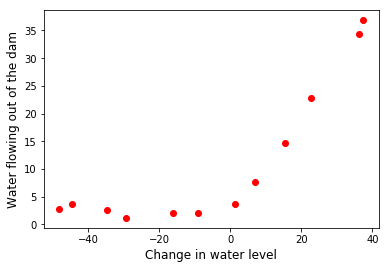

In [3]:
plt.scatter(X0,y, color='red')
plt.xlabel('Change in water level',fontsize=12)
plt.ylabel('Water flowing out of the dam',fontsize=12)
plt.show()

## Definitions of functions for regularized linear regression model

In [4]:
# Hypothesis function.
# This function returns m x 1 vector
def Hypothesis(theta_f,Xf):
    mf=Xf.shape[0]    
    return np.matmul(Xf,theta_f) # m x 1 vector

# Cost function.
# This function returns the cost (scalar)
def RegCostFunctionJ(theta_f,lambda_f,Xf,yf):
# X: m x n matrix, where m is the number of training set and n is the number of features
# y: m x 1 vector.
# theta: n x 1 vector 

    mf=Xf.shape[0]
    beta_f=Hypothesis(theta_f.reshape(-1,1),Xf)-yf
    
    reg_term=0.5* lambda_f/mf*np.dot(theta_f[1:].reshape(-1,1).T,theta_f[1:].reshape(-1,1))
    return 0.5 * np.dot(beta_f.T,beta_f) / mf + reg_term

def GradRegCost(theta_f,lambda_f,Xf,yf):
    mf=Xf.shape[0]
    nf=Xf.shape[1]
    hf=Hypothesis(theta_f.reshape(-1,1),Xf)      

    temp=1/mf * np.matmul(Xf.T,hf-yf)
    
    reg_term=(lambda_f/mf)*np.r_[[[0]],theta_f[1:].reshape(-1,1)]
    ret=temp+reg_term
    return ret.flatten()

In [5]:
theta_test=np.ones((2,1))
lambda_test=1
print("The calculated cost: %0.6f"%RegCostFunctionJ(theta_test, lambda_test, X,y))
print('The expected cost: 303.993192')
print('The calculated gradient: %0.6f, %0.6f'%(GradRegCost(theta_test,lambda_test,X,y)[0],GradRegCost(theta_test,lambda_test,X,y)[1]))
print('The expected gradient: -15.303016, 598.250744')

The calculated cost: 303.993192
The expected cost: 303.993192
The calculated gradient: -15.303016, 598.250744
The expected gradient: -15.303016, 598.250744


## Minimization of the cost function

In [6]:
def GetOptTheta(theta_init_f,lambda_f,num_iter_f,Xf,yf):
## Minimizing the cost
    return minimize(fun=RegCostFunctionJ,x0= theta_init_f, args=(lambda_f, Xf, yf), method='CG', jac=GradRegCost, options={'maxiter':num_iter_f,'disp':False})

In this part, the regularization parameter &lambda; is set to be zero because regularization is not so helpful for a &theta; of such low dimension.

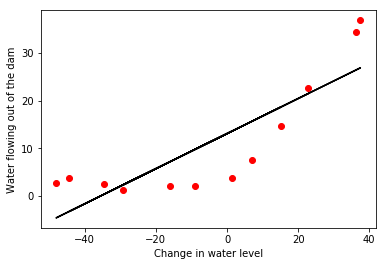

In [7]:
theta_init=np.zeros((2,1))
lambda_test=0
num_iter=50

result=GetOptTheta(theta_init,lambda_test,num_iter,X,y)
opttheta=result.x

plt.scatter(X0,y, color='red')
plt.plot(X[:,1],np.matmul(X,opttheta.reshape(-1,1)), color='black')
plt.xlabel('Change in water level')
plt.ylabel('Water flowing out of the dam')
plt.show()

The best fit line shown above tells us that the linear model is not good because the data has a non-linear pattern. 

## Learning curve

Visualization of data and fit results is a good way to evaluate the model. However, it is not always easy to visualize the data and model. Showing learning curves is one of the possible ways to evaluate the model.

Learning curve is an error plotted as a function of the number of the training examples. In order to show this curve, different subsets of the original training data should be prepared. Error can be calculated using the cost function without regularizaation (&lambda; = 0). It should be noted that error for the cross validation set is calculated for all cross validation dataset while that for the training set is calculated for different sizes of subsets of the original training data (i.e., Xtrain[:i+1,:], y[:i+1,:]).

In [8]:
def LearningCurve(lambda_f,num_iter_f,Xf_train,yf_train,Xf_val,yf_val):
    mf=Xf_train.shape[0]
    nf=Xf_train.shape[1]
    
    error_train=np.zeros((mf,1))
    error_val=np.zeros((mf,1))
    num_train_sample=np.zeros((mf,1))
    
    for i in range(mf):
        theta_init_f=np.zeros((nf,1))
        
        theta_f=GetOptTheta(theta_init_f, lambda_f, num_iter_f, Xf_train[:i+1,:], yf_train[:i+1,:]).x
        
        error_train[i]=RegCostFunctionJ(theta_f,0,Xf_train[:i+1,:],yf_train[:i+1,:])
        error_val[i]=RegCostFunctionJ(theta_f,0,Xf_val,yf_val)
        
        num_train_sample[i]=i+1
    return [num_train_sample,error_train,error_val]

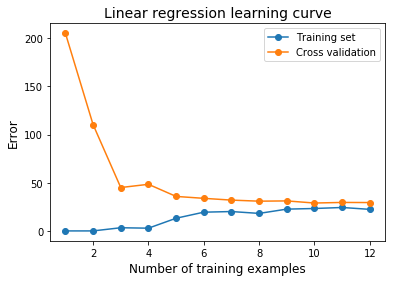

In [9]:
num_iter=10
lambda_test=0
Errors=LearningCurve(lambda_test, num_iter, X, y, Xval, yval)

plt.plot(Errors[0],Errors[1],label='Training set',marker='o')
plt.plot(Errors[0],Errors[2],label='Cross validation',marker='o')
plt.xlabel('Number of training examples',fontsize=12)
plt.ylabel('Error',fontsize=12)
plt.title('Linear regression learning curve',fontsize=14)
plt.legend()
plt.show()

In the figure shown above, both the training set error and cross validation error are high when the number of training set is increased. This reflects a high bias problem in the model. In other words, the linear regression model underfits the given data. 

## Polynomial regression

More features can be created by taking polynomial terms (x<sup>2</sup>, x<sup>3</sup>,...) into account. If you consider high degree of polynomial, their values will be very large (e.g., consider x and x<sup>10</sup>). The large difference in the feature values is not good for training the model. Therefore, feature normalization should be performed.  

In [10]:
def polyFeatures(Xf,pf):
    temp=copy.deepcopy(Xf[:,1].reshape(-1,1))

    if 1<pf: #pf=2,3,4,5...
        for j in range(2,pf+1):
            Xf=np.c_[Xf,temp**(j)]
    return Xf

In [11]:
def FeatureNormalization(Xf):
    nf=Xf.shape[1]

    Xret=copy.deepcopy(Xf)
    
    if 2<nf: #nf=3,4,5...
        Xave=np.zeros(nf-1)
        Xstdv=np.zeros(nf-1)    

        for j in range(1,nf):
            Xave[j-1]=np.mean(Xf[:,j])
            Xstdv[j-1]=stdev(Xf[:,j])
            Xret[:,j]=(Xret[:,j]-Xave[j-1])/Xstdv[j-1]

    else: #nf=2
            Xave=np.mean(Xf[:,1])
            Xstdv=stdev(Xf[:,1])
            Xret[:,1]=(Xret[:,1]-Xave)/Xstdv
            
    return [Xret,Xave,Xstdv]

In the next cell, making polynomial features, feature normalization, minimization of the cost function for the normalized dataset will be performed. The fitting curve and dataser will be visualized.

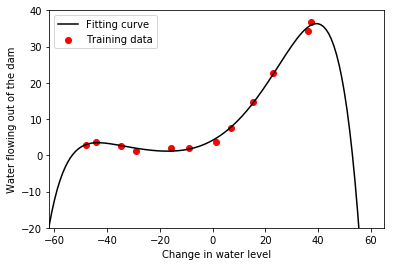

In [12]:
p=8

##Preparing polynomial features
Xpoly=FeatureNormalization(polyFeatures(X,p))[0]
n_poly=Xpoly.shape[1] #numbe of new features

## Initial conditions
theta_init=np.zeros((n_poly,1))
lambda_test=0
num_iter=50

##Optimization
result=GetOptTheta(theta_init, lambda_test, num_iter, Xpoly, y)
opttheta=result.x.reshape(-1,1)

##For drawing the fitting curve
def plotFittingCurve(theta_f, ave_f, stdv_f, pf):
    xtemp_f   = np.linspace(-70,70,141).reshape(-1,1)
    xtemp2_f = polyFeatures( np.c_[np.ones((xtemp_f.shape[0],1)),xtemp_f] , pf)
    nf=xtemp2_f.shape[0]

    for j in range(nf): 
        xtemp2_f[j,1:]=(xtemp2_f[j,1:]-ave_f)/stdv_f

    plt.scatter(X0,y, color='red',label='Training data')
    plt.plot(xtemp_f,np.matmul(xtemp2_f,theta_f), color='black',label='Fitting curve')

    plt.xlabel('Change in water level')
    plt.xlim(-62,65)
    plt.ylim(-20,40)
    plt.ylabel('Water flowing out of the dam')
    plt.legend(loc='upper left')
#    plt.show()

    
plotFittingCurve(opttheta,FeatureNormalization(polyFeatures(X,p))[1],FeatureNormalization(polyFeatures(X,p))[2],p)
plt.show()

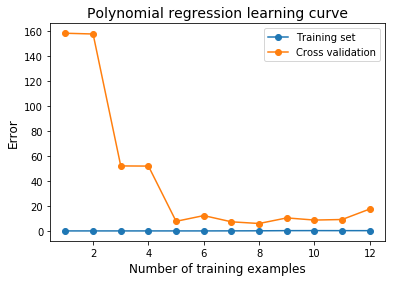

In [13]:
##Preparing polynomial features
Xpoly=FeatureNormalization(polyFeatures(X,p))[0]
Xval_poly=FeatureNormalization(polyFeatures(Xval,p))[0]

n_poly=Xpoly.shape[1]
theta_init=np.zeros((n_poly,1))
Errors=LearningCurve(lambda_test, num_iter, Xpoly, y, Xval_poly, yval)

plt.plot(Errors[0],Errors[1],label='Training set',marker='o')
plt.plot(Errors[0],Errors[2],label='Cross validation',marker='o')
plt.xlabel('Number of training examples',fontsize=12)
plt.ylabel('Error',fontsize=12)
plt.title('Polynomial regression learning curve',fontsize=14)
plt.legend()
plt.show()

There is a gap between the training and cross validation errors, indicating a high variance problem (overfitting).

## Adjustment of the regularization parameter in the polynomial regression model

One way to overcome the overfitting (high-variance) problem is to add regularization to the model.

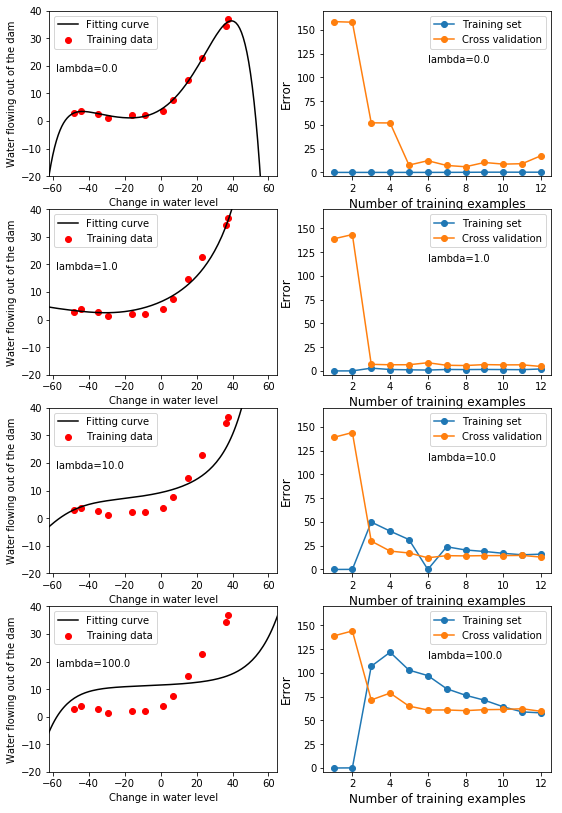

In [14]:
p=8

##Preparing polynomial features
Xpoly=FeatureNormalization(polyFeatures(X,p))[0]
n_poly=Xpoly.shape[1] #numbe of new features

## Initial conditions
theta_init=np.zeros((n_poly,1))

lambda_set=np.array([0,1,10,100])
num_iter=50

plt.figure(figsize=(9,14))

for j in range(lambda_set.shape[0]):
    lambda_test=lambda_set[j]

##Optimization
    result=GetOptTheta(theta_init, lambda_test, num_iter, Xpoly, y)
    opttheta=result.x.reshape(-1,1)

    temp="42%d"%(2*j+1)
        
    plt.subplot(temp)
    plotFittingCurve(opttheta,FeatureNormalization(polyFeatures(X,p))[1],FeatureNormalization(polyFeatures(X,p))[2],p)
    plt.text(-58,18, 'lambda=%0.1f'%lambda_set[j])
    
##Learning curve    
    Errors=LearningCurve(lambda_test, num_iter, Xpoly, y, Xval_poly, yval)
    temp="42%d"%(2*(j+1))
    plt.subplot(temp)
    plt.plot(Errors[0],Errors[1],label='Training set',marker='o')
    plt.plot(Errors[0],Errors[2],label='Cross validation',marker='o')
    plt.xlabel('Number of training examples',fontsize=12)
    plt.ylabel('Error',fontsize=12)
    plt.ylim(-4,170)
    plt.text(6,115, 'lambda=%0.1f'%lambda_set[j])
    plt.legend()

plt.show()

## Validation curve

From the previous section, we can see that a model without regularization (&labmda; = 0) fits the  training set very well, but does not generalize. In addition, too much regularization (&lambda; = 100) is not appropreate for fitting the training set. There is an optimal &lamda;.

In the next two cells, error is plotted as a function of &lambda;. An optimal &theta; can be found from the position where the error for the cross validation is small. 

In [17]:
def ValidationCurve(num_iter_f,Xf_train,yf_train,Xf_val,yf_val):

    lambda_set=np.array([0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1,3, 10])

    num_lam=lambda_set.shape[0]
    
    nf=Xf_train.shape[1]
    
    error_train=np.zeros((num_lam,1))
    error_val=np.zeros((num_lam,1))
    xaxis_lambda=np.zeros((num_lam,1))

    for i in range(num_lam):
        lambda_f=lambda_set[i]

        theta_init_f=np.zeros((nf,1))
        
        theta_f=GetOptTheta(theta_init_f, lambda_f, num_iter_f, Xf_train, yf_train).x
        
        error_train[i]=RegCostFunctionJ(theta_f,0,Xf_train,yf_train)
        error_val[i]=RegCostFunctionJ(theta_f,0,Xf_val,yf_val)
        
        xaxis_lambda[i]=lambda_f
        
    return [xaxis_lambda,error_train,error_val]

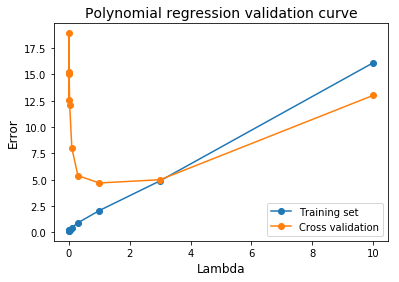

In [18]:
##Preparing polynomial features
p=8

Xpoly=FeatureNormalization(polyFeatures(X,p))[0]
Xval_poly=FeatureNormalization(polyFeatures(Xval,p))[0]

num_iter=100

Errors=ValidationCurve(num_iter,Xpoly,y,Xval_poly,yval)

plt.plot(Errors[0],Errors[1],label='Training set',marker='o')
plt.plot(Errors[0],Errors[2],label='Cross validation',marker='o')
plt.xlabel('Lambda',fontsize=12)
plt.ylabel('Error',fontsize=12)
plt.title('Polynomial regression validation curve',fontsize=14)
plt.legend(loc='lower right')
plt.show()